In [1]:
from importlib import reload
from src import data_setup, engine, models, utils
[reload(module) for module in [data_setup, engine, models, utils]]; # During Development

In [2]:
# Verify installation and initialize computing device
device = engine.initialize()

[CONNECTED] NVIDIA GeForce RTX 3070


In [3]:
url = 'https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip'
datapath = data_setup.download_data('data', url, dataset_name='PSS_0.1')

[INFO] 'PSS_0.1' dataset already exist. Download skipped.


In [4]:
from torchvision.transforms import Compose, Resize, TrivialAugmentWide

IMG_SIZE = 224
BATCH_SIZE = 4

common = [ Resize(size=(IMG_SIZE,IMG_SIZE)) ]
transforms = [
    Compose(common + [TrivialAugmentWide(num_magnitude_bins=8)]),
    Compose(common),
]

train_loader, val_loader, test_loader, classes = data_setup.create_dataloaders(
    directories=[datapath/'train', datapath/'test'],
    transforms=transforms,
    splits=[(0.85, 0.15), None],
    shuffles=[True, False],
    batch_size=BATCH_SIZE,
    num_workers=2,
    device=device
)

Loader#0: 192 samples
Loader#1: 36 samples
Loader#2: 76 samples
Target: ['pizza', 'steak', 'sushi']


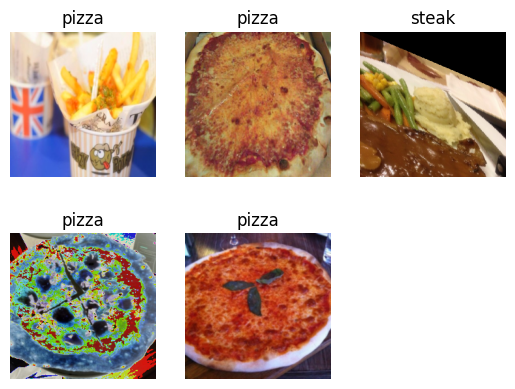

Shutting down workers at [23040, 8844]


In [5]:
utils.visualize(train_loader, n=5, classes=classes)
train_loader.restart()

### Custom Transformer

In [6]:
LAYERS = 12  # The number of transformer encoder blocks
EMBEDDING_DIM = 768  # Embedding dimension for each token
MLP_SIZE = 3072  # The size of the hidden layer in the MLP
NUM_HEADS = 12  # The number of attention heads
PATCH_SIZE = 16  # The size of each image patch

model = models.ViT(
    IMG_SIZE,
    output_shape=len(classes),
    patch_size=PATCH_SIZE,
    emb_dim=EMBEDDING_DIM,
    depth=LAYERS,
    heads=NUM_HEADS,
    mlp_dim=MLP_SIZE,
    dropout=0.1,
    dropout_head=0.0,
    custom_architecture=False
).to(device)

model.summary()

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
ViT                                      [1, 3, 224, 224]     [1, 3]               --                   True
├─PatchEncoder: 1-1                      [1, 3, 224, 224]     [1, 197, 768]        152,064              True
│    └─Sequential: 2-1                   [1, 3, 224, 224]     [1, 768, 196]        --                   True
│    │    └─Conv2d: 3-1                  [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    │    └─Flatten: 3-2                 [1, 768, 14, 14]     [1, 768, 196]        --                   --
│    └─Dropout: 2-2                      [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential: 1-2                        [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderLayer: 2-3      [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    └─Transformer

In [7]:
# Weight decay a regularization technique (L2 norm)
trainer = engine.ClassTrainer(model=model, lr=5e-2, lr_decay=0.985, writer=False, progress=True, optimizer_kwargs={'weight_decay': 0.1})
trainer.run(train_loader, val_loader, epochs=10, experiment_name='ViT_FirstRun', model_name='ViT')

[INFO] Initializing Training Process - First Evaluation
[INFO] Training Started.
--------------------
[01] ########## [100.0%] | train: l=7.13, a=032.29% [0.08/4.25s] | val: l=1.14, a=033.33% | lr=0.050000
[02] ########## [100.0%] | train: l=1.17, a=027.60% [0.08/3.86s] | val: l=1.10, a=033.33% | lr=0.049250
[03] ########## [100.0%] | train: l=1.15, a=033.33% [0.08/3.86s] | val: l=1.10, a=033.33% | lr=0.048511
[04] ########## [100.0%] | train: l=1.12, a=034.38% [0.08/3.87s] | val: l=1.11, a=033.33% | lr=0.047784
[05] ########## [100.0%] | train: l=1.15, a=032.81% [0.08/3.87s] | val: l=1.10, a=033.33% | lr=0.047067
[06] ########## [100.0%] | train: l=1.17, a=032.81% [0.08/3.88s] | val: l=1.13, a=033.33% | lr=0.046361
[07] ########## [100.0%] | train: l=1.24, a=033.33% [0.08/3.87s] | val: l=1.29, a=033.33% | lr=0.045665
[08] ########## [100.0%] | train: l=1.16, a=031.25% [0.08/3.87s] | val: l=1.11, a=033.33% | lr=0.044980
[09] ########## [100.0%] | train: l=1.21, a=034.38% [0.08/3.88s] |

'2023-06-16_Evaar'

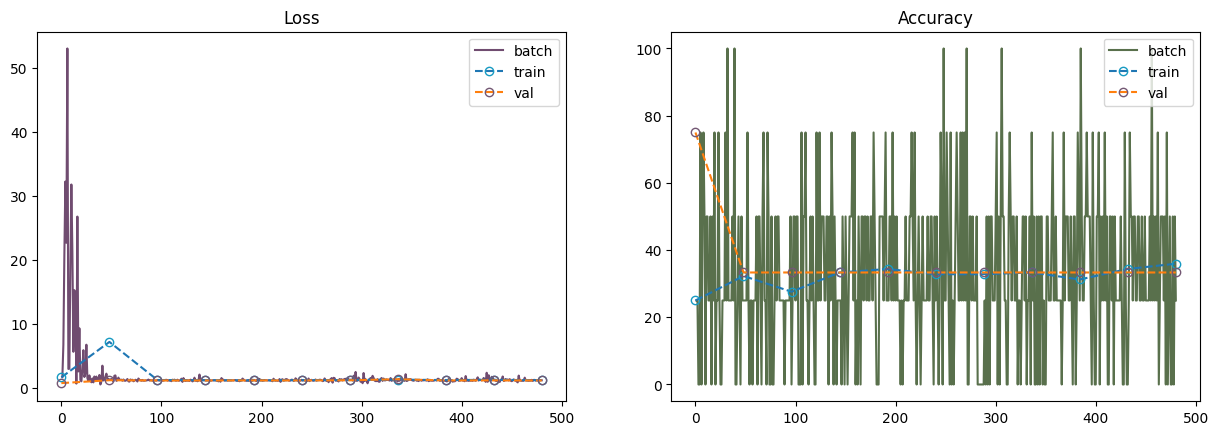

In [8]:
utils.plot_progress(trainer.progress)

[036.8%][100.0%]

Shutting down workers at [14324, 6608]
Mean Average Values:
--------------------
Loss		1.1037
Acc			0.2533
Precision	0.0844
Recall		0.3333
F1 Score	0.1348
AUC			0.5000


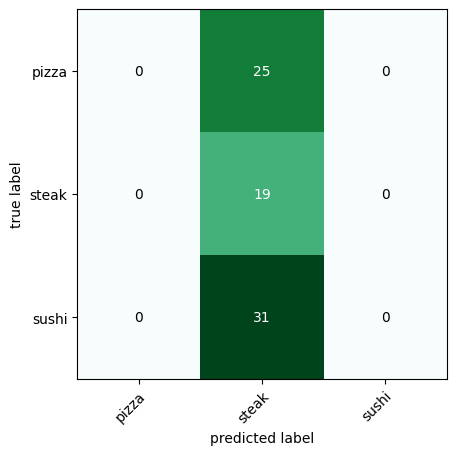

In [9]:
trainer.evaluate(test_loader, classes=classes)

### Fine-Tuning a Pre-Trained Transformer

In [10]:
[loader.restart() for loader in [train_loader, val_loader, test_loader]];

In [11]:
from types import MethodType
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torch import nn

common = ViT_B_16_Weights.DEFAULT.transforms()
transforms = [
    Compose([TrivialAugmentWide(num_magnitude_bins=8), common]),
    Compose(common),
]
model = vit_b_16(
    weights=ViT_B_16_Weights.DEFAULT
).to(device)

for param in model.parameters():
    param.requires_grad = False

model.heads = nn.Sequential(
    nn.Linear(768, len(classes), bias=True)
)

model.summary = MethodType(utils.summary([1, 3, IMG_SIZE, IMG_SIZE]), model)
model.summary()

Layer (type:depth-idx)                        Input Shape          Output Shape         Param #              Trainable
VisionTransformer                             [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d: 1-1                                 [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder: 1-2                                [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout: 2-1                           [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential: 2-2                        [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]        [1, 197, 768]        --                   False
│    │    │    └─LayerNorm: 4-1               [1, 197, 768]        [1, 197, 768]        (1,536)              False
│    │    │    └─MultiheadAttention: 4-2      [1, 197, 768]        [1, 197, 7

In [12]:
trainer = engine.ClassTrainer(model=model, lr=5e-3, lr_decay=0.9, writer=False, progress=True, optimizer_kwargs={'weight_decay': 0.1})
trainer.run(train_loader, val_loader, epochs=10, experiment_name='ViT_Pretrained', model_name='ViT16')

[INFO] Initializing Training Process - First Evaluation
[INFO] Training Started.
--------------------
[01] ########## [100.0%] | train: l=0.43, a=083.33% [0.02/1.22s] | val: l=0.23, a=087.88% | lr=0.005000
[02] ########## [100.0%] | train: l=0.18, a=095.31% [0.02/1.14s] | val: l=0.32, a=081.82% | lr=0.004500
[03] ########## [100.0%] | train: l=0.20, a=092.71% [0.02/1.16s] | val: l=0.21, a=090.91% | lr=0.004050
[04] ########## [100.0%] | train: l=0.16, a=095.31% [0.02/1.14s] | val: l=0.26, a=093.94% | lr=0.003645
[05] ########## [100.0%] | train: l=0.14, a=095.31% [0.02/1.15s] | val: l=0.27, a=084.85% | lr=0.003281
[06] ########## [100.0%] | train: l=0.15, a=095.83% [0.02/1.14s] | val: l=0.23, a=087.88% | lr=0.002952
[07] ########## [100.0%] | train: l=0.14, a=096.35% [0.02/1.15s] | val: l=0.38, a=075.76% | lr=0.002657
[08] ########## [100.0%] | train: l=0.18, a=093.23% [0.02/1.14s] | val: l=0.22, a=087.88% | lr=0.002391
[09] ########## [100.0%] | train: l=0.16, a=094.79% [0.02/1.14s] |

'2023-06-16_Evaar'

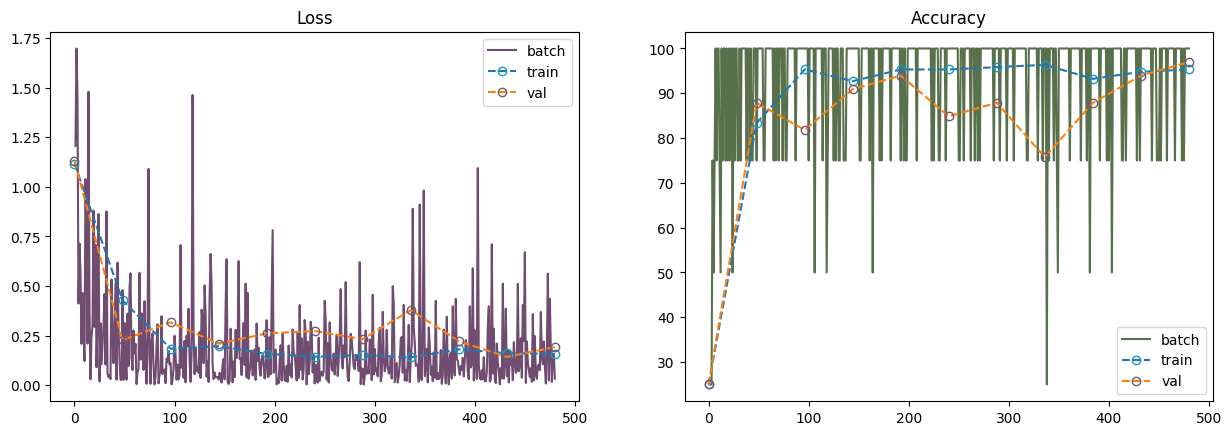

In [13]:
utils.plot_progress(trainer.progress)

[026.3%][100.0%]

Shutting down workers at [14900, 13564]
Mean Average Values:
--------------------
Loss		0.2077
Acc			0.9200
Precision	0.9184
Recall		0.9125
F1 Score	0.9152
AUC			0.9881


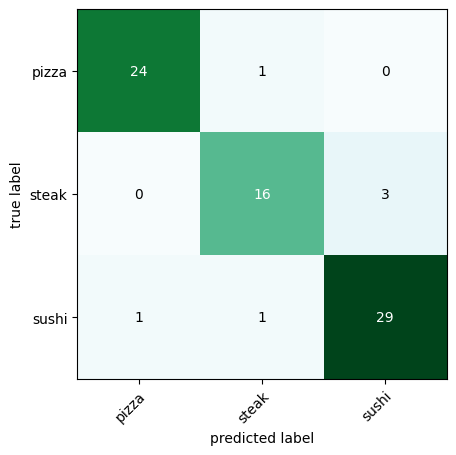

In [14]:
trainer.evaluate(test_loader, classes=classes)

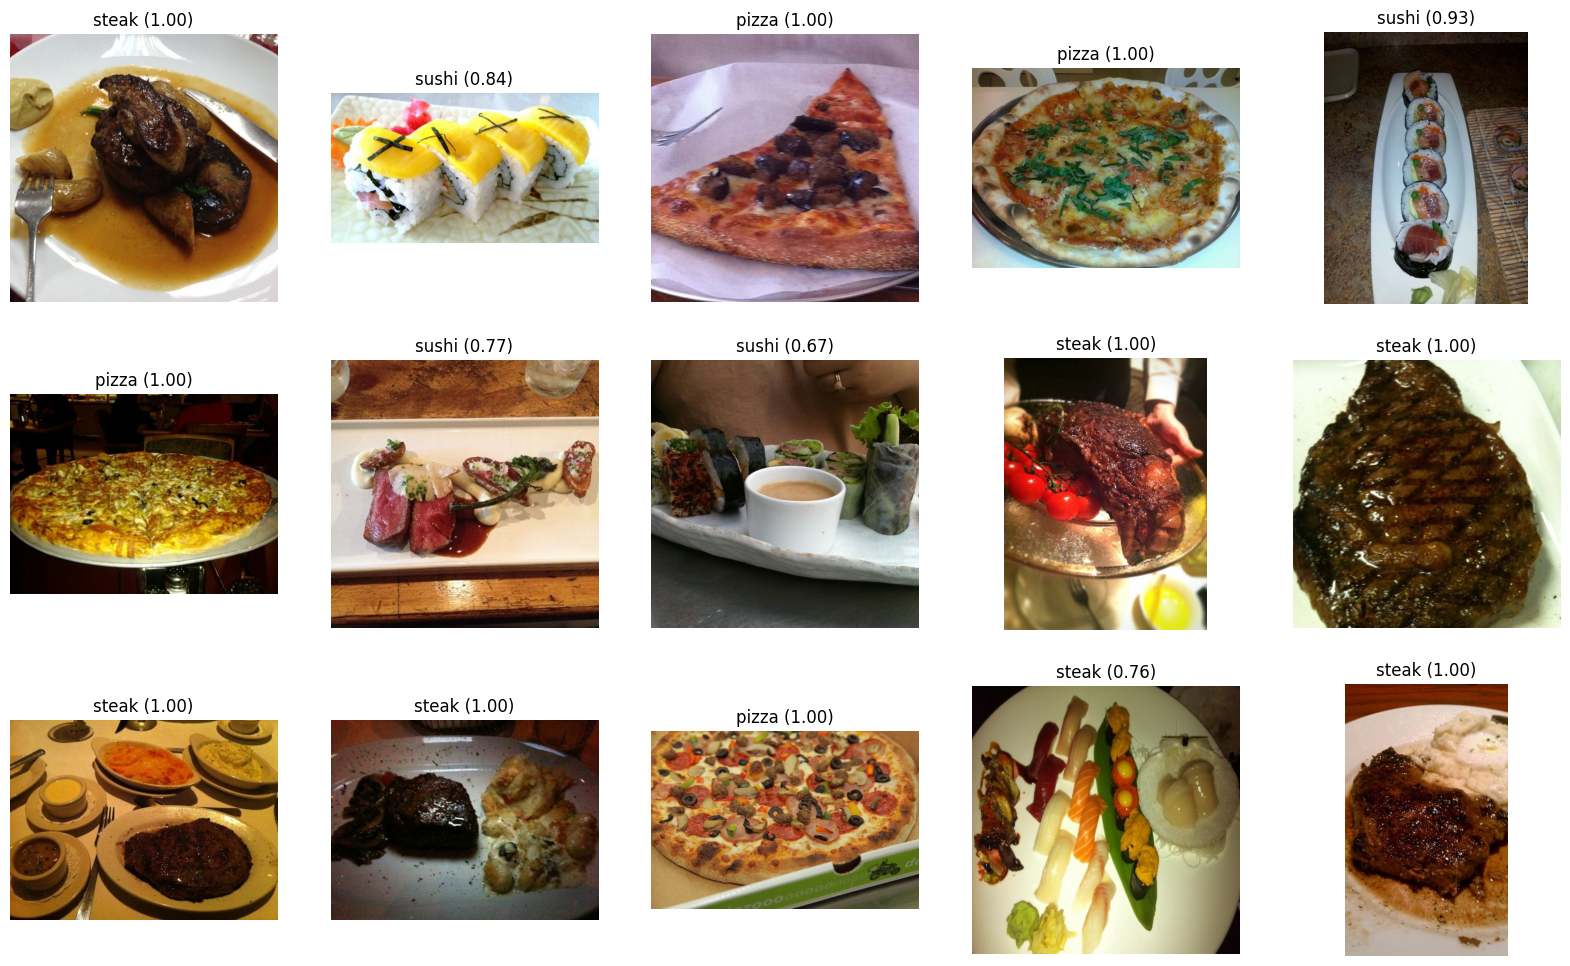

In [15]:
engine.inference(model, datapath/'test', classes=classes, n=15, transform=common, device=device)

In [16]:
utils.save_model(model, directory='models', filename='ViT16_FineTuned.pt')

Saving model into 'models\ViT16_FineTuned.pt'
Total size = 327.36 MB
